In [7]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pylab as plt
from modules import *
from data import *

In [2]:
data_generator = GeneratorFromLorenzAttractor()

# 1- Training a model to fit the sequence from Lorenz attractor:

In [4]:
Nx = 2**4
Ny = 3
Nlayers = 2
Nseq = 2**6

Nepoch = 2**7
Nbatch = 2**5

run_training = False

In [5]:
model = Predictor(Nx, Ny, Nlayers)

In [8]:
if os.path.exists('model.pt') and not run_training:
    model.load_state_dict(torch.load('model.pt'))

In [9]:
if run_training:
    loss_hist = []
    optimizer = torch.optim.Adam(model.parameters())
    Nitr = data_generator.Ntrain//Nbatch
    for epoch in range(Nepoch):
        tmp = []
        for k1 in range(Nitr):
            Y = data_generator.batch(Nbatch, Nlayers+Nseq) # (Nlayers+Nseq, *, 3)

            _Y0 = torch.tensor(Y[:Nlayers, :]) # (Nlayers, *, 3)
            _Y1 = torch.tensor(Y[Nlayers:, :]) # (Nseq, *, 3)

            _Y1hat = model(_Y0, Nseq) # (Nseq, *, 3)

            _loss = torch.mean((_Y1 - _Y1hat)**2)

            model.zero_grad()
            _loss.backward()
            optimizer.step()

            tmp.append(float(_loss))
        loss_hist.append((epoch, np.mean(tmp)))
        torch.save(model.state_dict(), 'model.pt')

In [11]:
if run_training:
    loss_hist_numpy = np.array(loss_hist)

    plt.figure()
    plt.plot(loss_hist_numpy[:,0], loss_hist_numpy[:,1])
    plt.xlabel('epoch')
    plt.ylabel('resid')
    plt.grid()
    plt.tight_layout()
    plt.savefig('./img/epoch_loss.png')

# 2- Check the prediction performance

In [59]:
Y = data_generator.batch(Nbatch=1, N = Nlayers + Nseq)
Y0 = Y[:Nlayers, :] # (Nlayers, *, 3)
Y1 = Y[Nlayers:, :] # (Nseq, *, 3)

_Y1hat = model(torch.tensor(Y0), Nseq) # (Nseq, *, 3)
Y1hat = _Y1hat.data.numpy() # (Nseq, *, 3)

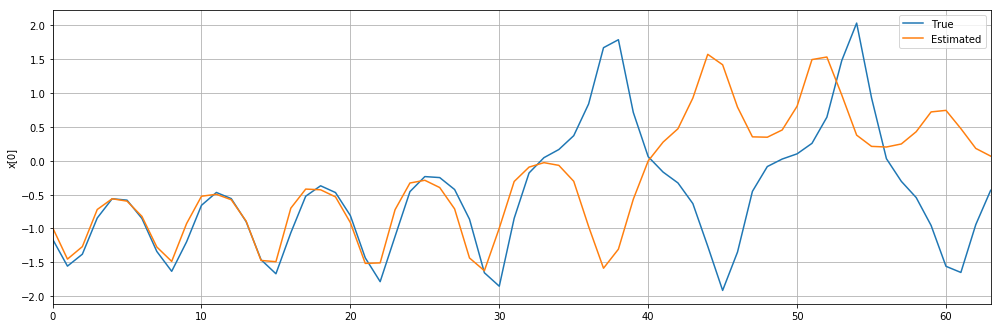

In [60]:
plt.figure(figsize=[36/2.57, 12/2.57])
plt.plot(Y1[:,0,0], label = 'True')
plt.plot(Y1hat[:,0,0], label = 'Estimated')
plt.ylabel('x[0]')
plt.xlim([0,63])
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('./img/estimation.png')